In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_selection import SelectKBest, chi2 #won't support categorical values
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
#Boosting
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

#Bagging
from sklearn.ensemble import RandomForestClassifier

# Custom functions

In [4]:
def data_viz(df, columns,target=None, plot_type="bar", orient='h'):
    # defining size of a subplot (breadth*length) depends on plots in a row 
    number_of_columns = len(columns)
    if plot_type == 'hist':
        plots_in_a_row = 4
    else:
        plots_in_a_row = 2     
        
    rows_required = round(number_of_columns/plots_in_a_row)
    number_of_rows =  1 if rows_required == 0 else rows_required #handle min columns required
    f, ax = plt.subplots(number_of_rows,plots_in_a_row, figsize=(22, 6*number_of_rows))
    
    #plotting graphs in a subplot
    if plot_type == 'hist':
        for col_name, subplot in zip(columns, ax.flatten()):
            sns.distplot(df[col_name], ax=subplot)
    elif plot_type == 'bar':
        for col_name, subplot in zip(columns, ax.flatten()):
            sns.countplot(df[col_name], ax=subplot)
    elif plot_type == 'box':
        for col_name, subplot in zip(columns, ax.flatten()):
            sns.boxplot(x=df[col_name],ax=subplot)
    elif plot_type == 'scatter':
        for col_name, subplot in zip(columns, ax.flatten()):
            sns.scatterplot(x=col_name, y=target,data=df ,ax=subplot)
    elif(plot_type=='bar_target'):
        for col_name, subplot in zip(columns, ax.flatten()):
            ct = pd.crosstab(df[col_name], df[target])
            ct.plot.bar(ax=subplot) #stacked=True for one-on-another
            

In [5]:
# Used Inter quartile Range (IQR)
def handle_outlier(columns, data_frame):
    for column in columns:
        IQR = data_frame[column].quantile(0.75) - data_frame[column].quantile(0.25)
        upper_bound = data_frame[column].quantile(0.75) + (1.5 *IQR)
        lower_bound = data_frame[column].quantile(0.25) - (1.5 *IQR)
        data_frame[column] = np.where(data_frame[column] > upper_bound, upper_bound, np.where(data_frame[column]<lower_bound, lower_bound, data_frame[column]))

In [6]:
def fill_prv_rating(row):
    if row['KPIs_met >80%'] == 1 and row['awards_won?'] == 1:
        if row['avg_training_score'] - row['mean_traing_score_by_region_dep'] >= -10:
            return 5.0
        else: 
            return 4.0
            
    elif row['KPIs_met >80%'] == 1 or row['awards_won?'] == 1:
        if row['avg_training_score'] - row['mean_traing_score_by_region_dep'] >= 0:
            return 4.0
        elif 0> row['avg_training_score'] - row['mean_traing_score_by_region_dep'] >= -15:
            return 3.0
        else:
            return 2.0
            
    else:
        if row['avg_training_score'] - row['mean_traing_score_by_region_dep'] >= 15:
            return 3.0
        elif 15 > row['avg_training_score'] - row['mean_traing_score_by_region_dep'] >= 0:
            return 2.0
        else:
            return 1.0
    

# Basic Analysis

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train = train_df
test = test_df
sample = pd.read_csv("sample_submission.csv")

train['is_train'] = 1
test['is_train'] = 0
test['is_promoted'] = 0
full = train.append(test)

In [8]:
full.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,is_train
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,1
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,1
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,1
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,1
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,1


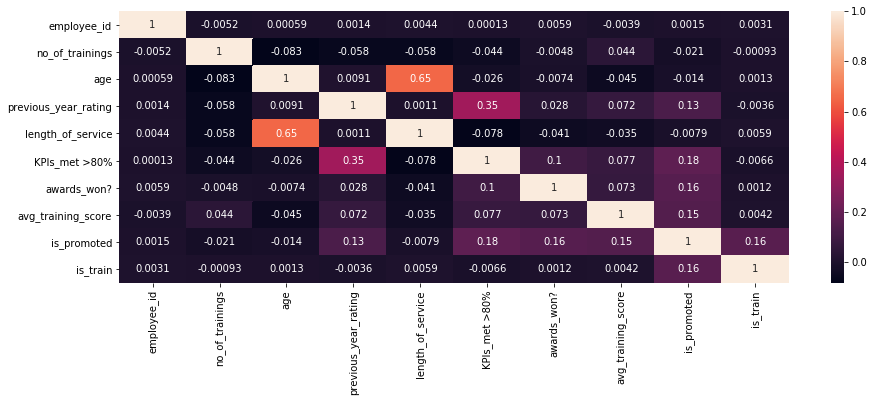

In [9]:
plt.figure(figsize=(15,5))
sns.heatmap(full.corr(), annot = True)

# Exploratory Data Analysis

In [10]:
numeric_columns = full.select_dtypes(exclude=['object']).columns.tolist()
numeric_columns.remove('employee_id')
numeric_columns.remove('no_of_trainings')
numeric_columns.remove('awards_won?')
numeric_columns.remove('KPIs_met >80%')
numeric_columns.remove('is_promoted')
numeric_columns.remove('is_train')

categoric_columns = full.select_dtypes(include=['object']).columns.tolist()
categoric_columns.append('no_of_trainings')
categoric_columns.append('awards_won?')
categoric_columns.append('KPIs_met >80%')
len(numeric_columns), len(categoric_columns)

(4, 8)

### 1. histogram

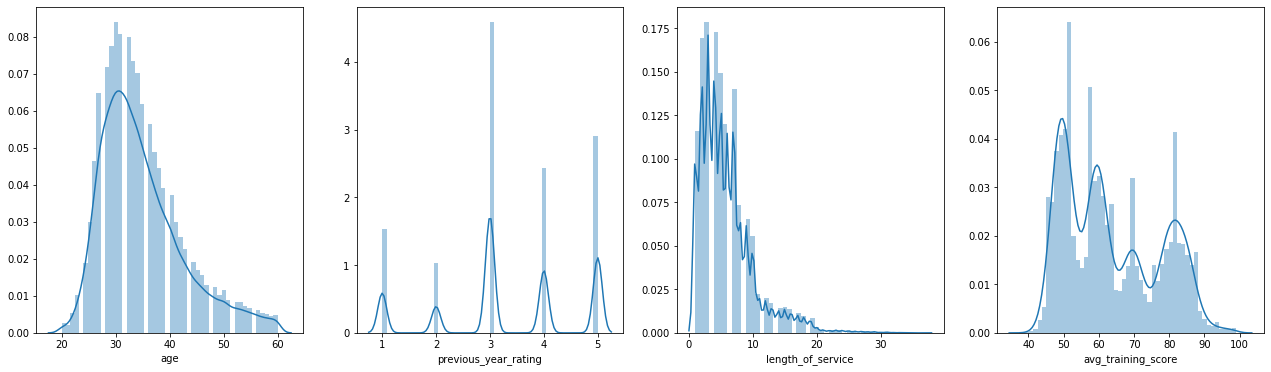

In [11]:
data_viz(df=full, columns=numeric_columns,plot_type="hist")

### 2. bar chart

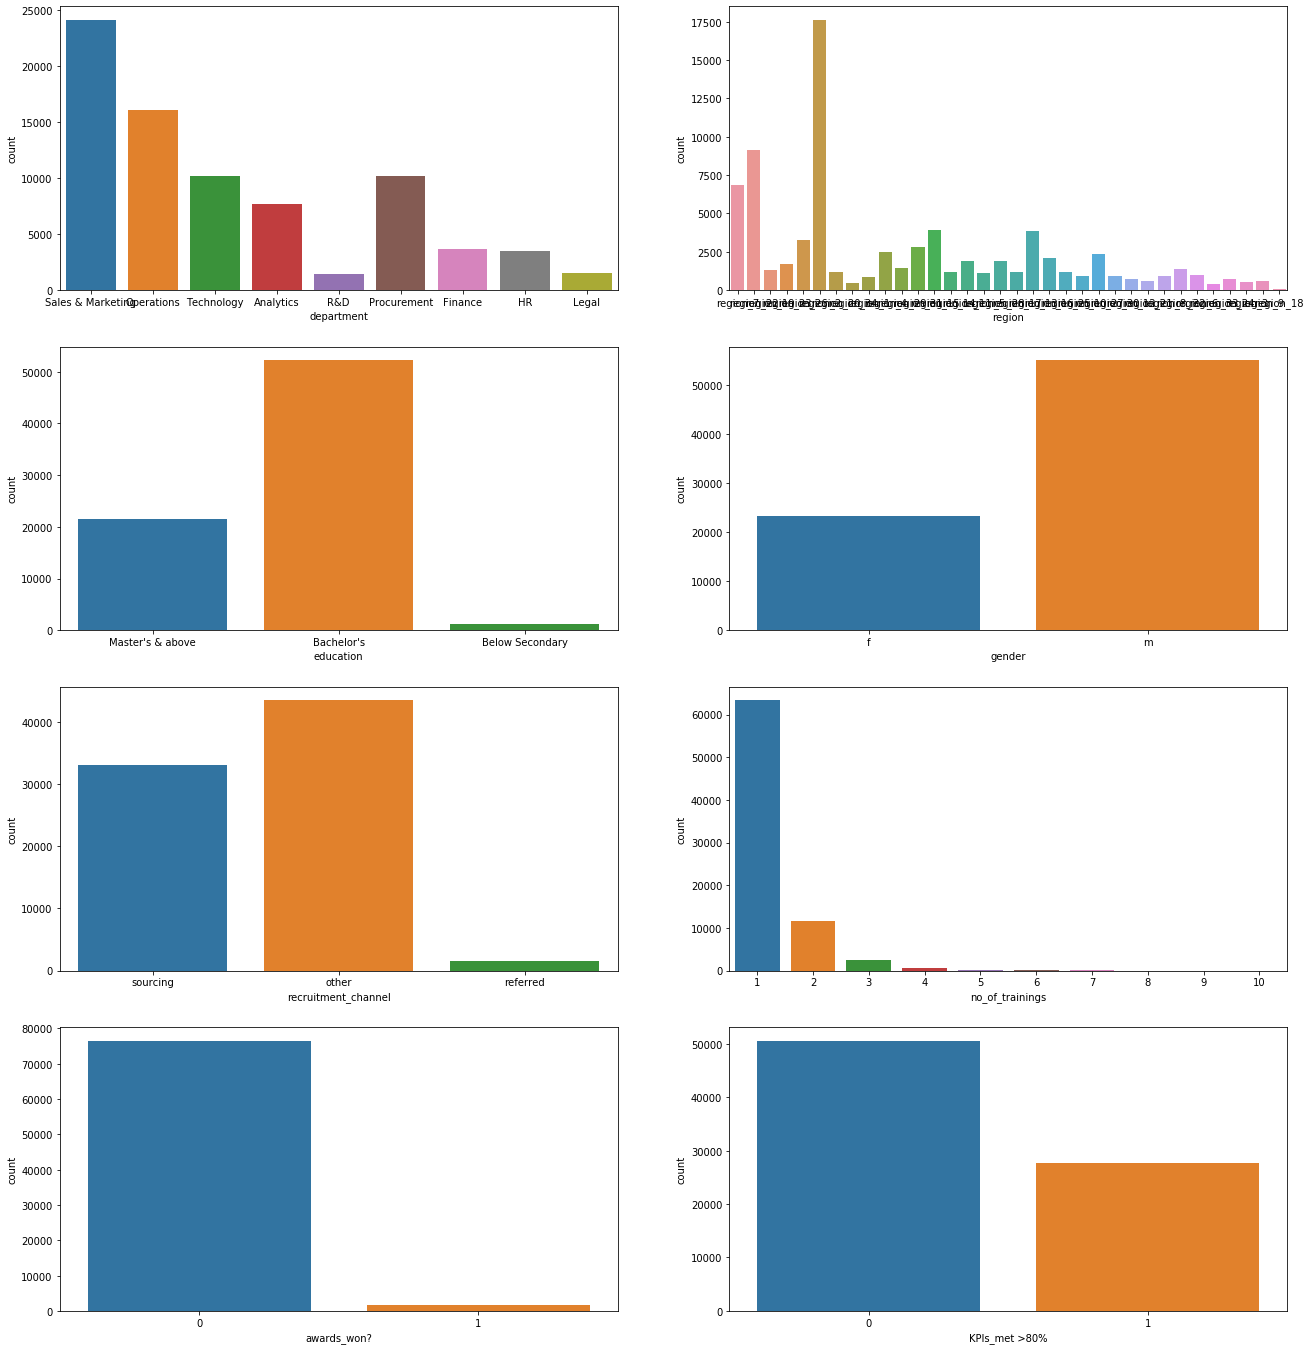

In [12]:
data_viz(df=full, columns=categoric_columns,plot_type="bar")

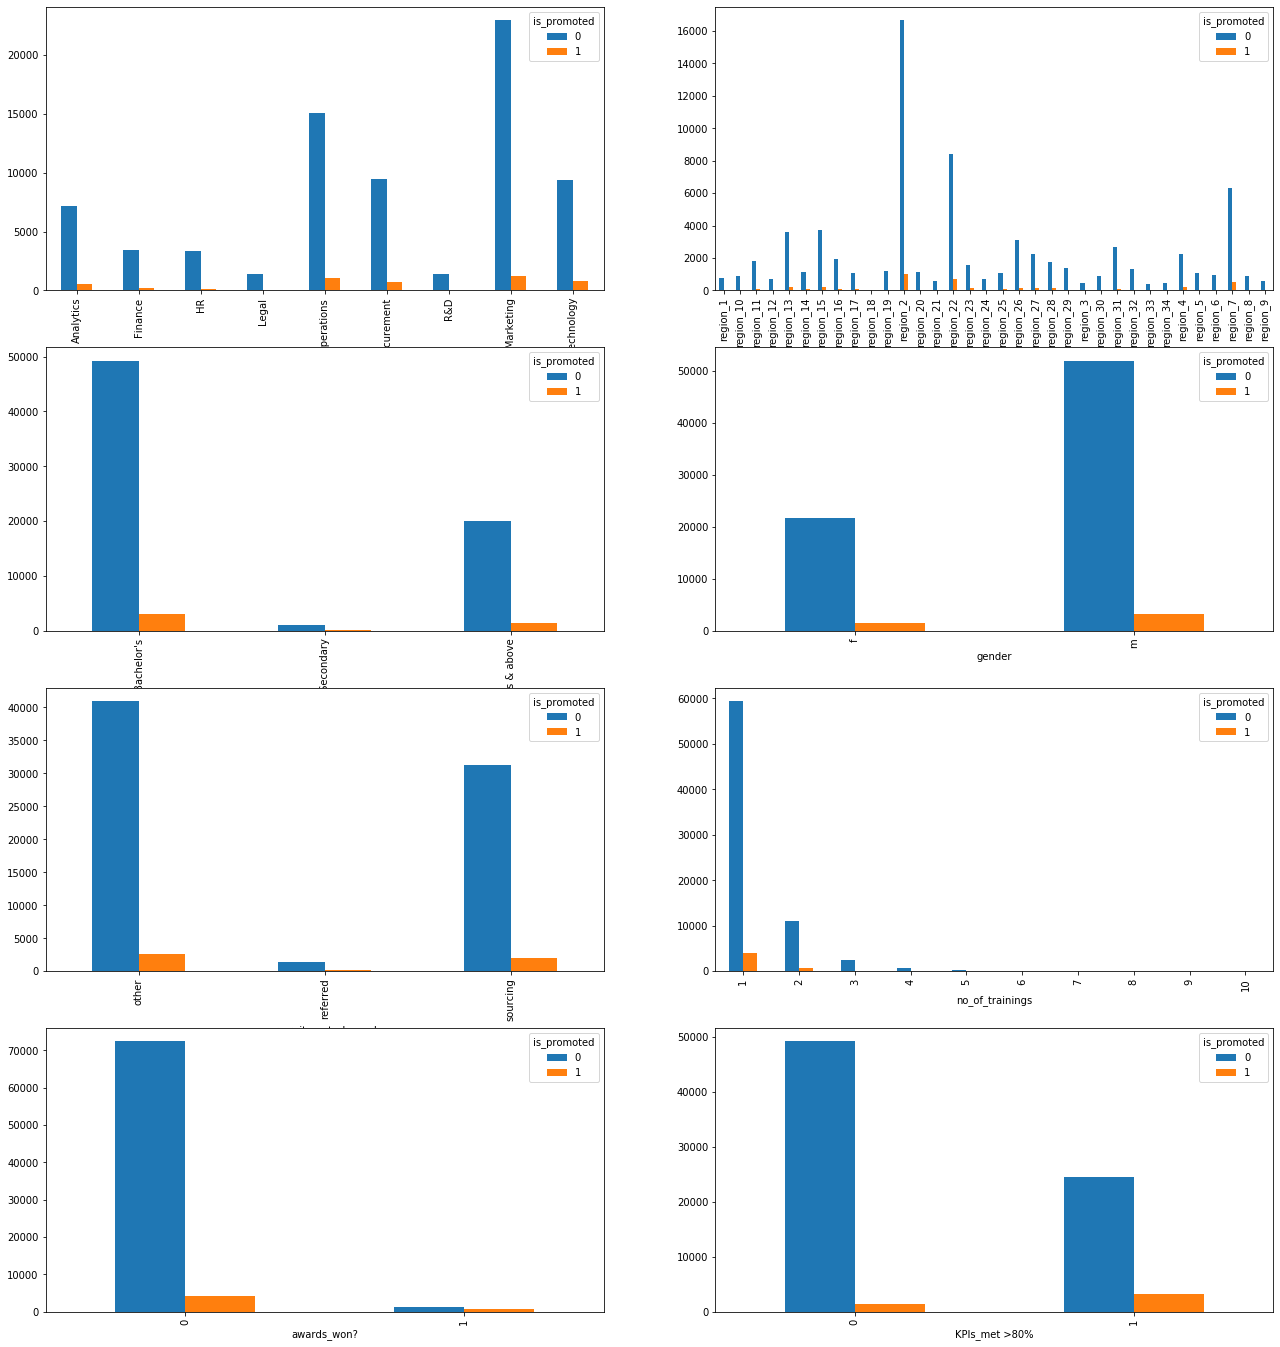

In [13]:
data_viz(df=full, columns=categoric_columns,target='is_promoted',plot_type="bar_target")

In [14]:
# data_viz(df=full, columns=categoric_columns,target='previous_year_rating',plot_type="bar_target")

### 3. box plot

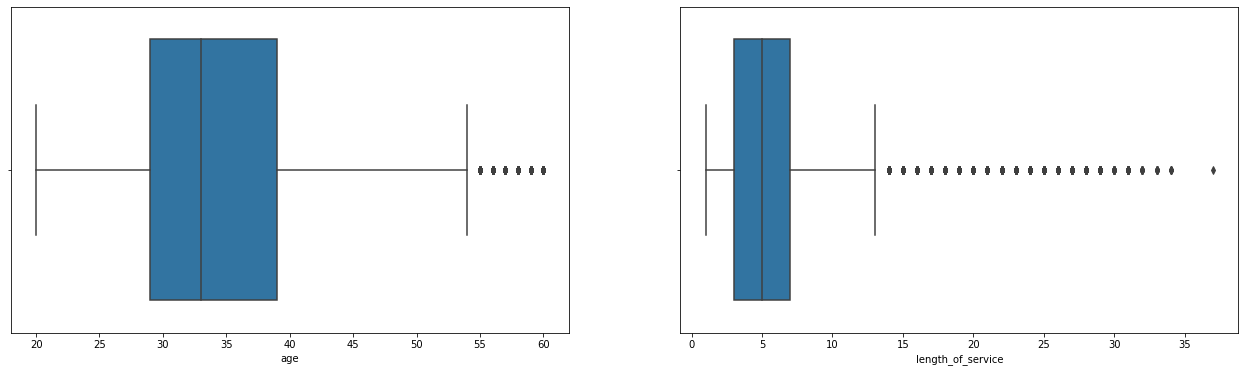

In [15]:
outlier_columns = ['age', 'length_of_service']
data_viz(df=full, columns=outlier_columns,plot_type="box")

## Outlier Treatment

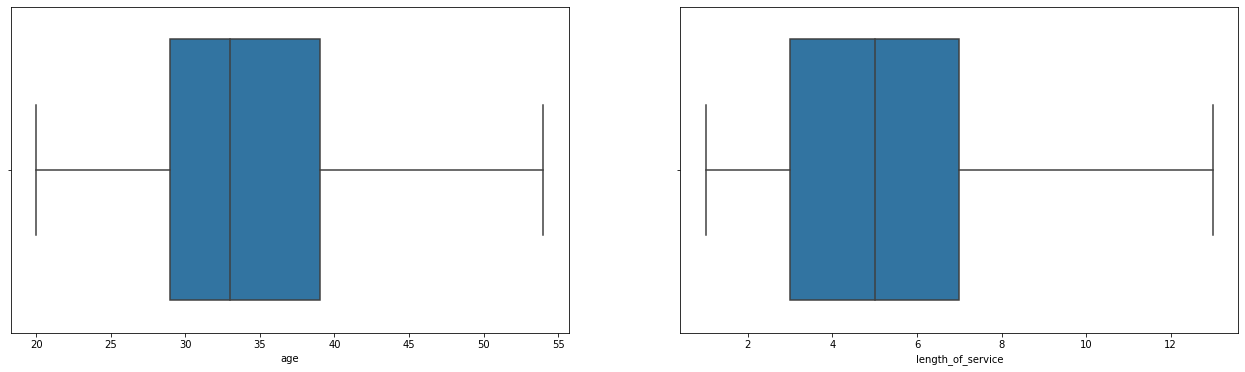

In [16]:
handle_outlier(outlier_columns, full)
data_viz(df=full, columns=outlier_columns,plot_type="box")

## Imputing missing values

In [17]:
full['education'].fillna(full['education'].mode()[0], inplace=True)
# full['previous_year_rating'].fillna(full['previous_year_rating'].mode()[0], inplace=True) # As missing values for service length 1

In [18]:
full[full['previous_year_rating'].isna() == True]['length_of_service'].value_counts()

1.0    5936
Name: length_of_service, dtype: int64

In [19]:
full[full['length_of_service']==1]['previous_year_rating'].value_counts(normalize=1, dropna=False)

NaN    0.907784
3.0    0.035479
4.0    0.023245
5.0    0.014834
1.0    0.010093
2.0    0.008564
Name: previous_year_rating, dtype: float64

In [20]:
# prev score missing only for 1st year empoyees, only 10% have value
# full['is_fresher'] = full['length_of_service'].apply(lambda x: 1 if x==1 else 0)

In [21]:
full['mean_traing_score_by_region_dep'] = full.groupby(['region', 'department','KPIs_met >80%', 'awards_won?'])['avg_training_score'].transform('mean')
# full['min_traing_score_by_region_dep'] = full.groupby(['region', 'department','KPIs_met >80%', 'awards_won?'])['avg_training_score'].transform('min')
# full['max_traing_score_by_region_dep'] = full.groupby(['region', 'department','KPIs_met >80%', 'awards_won?'])['avg_training_score'].transform('max')
# full['count_traing_score_by_region_dep'] = full.groupby(['region', 'department'])['employee_id'].transform('count')

In [22]:
full['previous_year_rating'] = full.apply(lambda row: fill_prv_rating(row) if np.isnan(row['previous_year_rating']) else row['previous_year_rating'], axis=1)

In [23]:
full.isna().sum()

employee_id                        0
department                         0
region                             0
education                          0
gender                             0
recruitment_channel                0
no_of_trainings                    0
age                                0
previous_year_rating               0
length_of_service                  0
KPIs_met >80%                      0
awards_won?                        0
avg_training_score                 0
is_promoted                        0
is_train                           0
mean_traing_score_by_region_dep    0
dtype: int64

In [24]:
# data_viz(df=full, columns=['KPIs_met >80%'],target='previous_year_rating',plot_type="bar_target")

In [25]:
# data_viz(df=full, columns=numeric_columns,plot_type="hist")

In [26]:
# data_viz(df=freshers, columns=categoric_columns,plot_type="bar")

In [27]:
# data_viz(df=freshers, columns=categoric_columns,target='is_promoted',plot_type="bar_target")

# Encoding

### 1. Label Encoding

In [28]:
#label_encoder = preprocessing.LabelEncoder()
# full['education'] = label_encoder.fit_transform(full['education'])
full['education'] = full['education'].map({'Below Secondary':0, "Bachelor's":1, "Master's & above":2})

# Feature Selection

In [29]:
temp_y = full['is_promoted']
temp_X = full.drop(['is_promoted', 'is_train','employee_id', 'department','region','gender', 'recruitment_channel'], axis=1)
best_feature_model = SelectKBest(score_func=chi2, k='all')
best_feature_model.fit(temp_X, temp_y)

#feature_model = ExtraTreesClassifier()
#feature_model.fit(temp_X,temp_y)

SelectKBest(k='all', score_func=<function chi2 at 0x7f8dcd675560>)

In [30]:
feature_df = pd.DataFrame(best_feature_model.scores_)
col = pd.DataFrame(temp_X.columns)

df = pd.concat([col, feature_df], axis=1)
df.columns = ['col_name', 'score']
display(print(df.nlargest(50, 'score')))

                          col_name        score
7               avg_training_score  4984.267742
6                      awards_won?  2013.446454
5                    KPIs_met >80%  1666.628645
3             previous_year_rating   721.113814
8  mean_traing_score_by_region_dep   540.405568
2                              age    23.372568
1                  no_of_trainings     9.932464
0                        education     7.004857
4                length_of_service     4.211497


None

# Feature Engineering

In [31]:
# Based on feature importance
anlysis_df = full.groupby('is_promoted')
promted = anlysis_df.get_group(1).sort_values('avg_training_score')
non_promoted = anlysis_df.get_group(0).sort_values('avg_training_score', ascending=False)

In [32]:
print('----Promoted----')
print('Min ->  ' + str(promted['avg_training_score'].min()))
print('Max ->  ' + str(promted['avg_training_score'].max()))
print('')
print('----Not Promoted----')
print('Min ->  ' + str(non_promoted['avg_training_score'].min()))
print('Max ->  ' + str(non_promoted['avg_training_score'].max()))

----Promoted----
Min ->  41
Max ->  99

----Not Promoted----
Min ->  39
Max ->  99


In [33]:
# 'KPIs_met >80%'
# 'awards_won?'
# no_req_met_promoted = promted[(promted['KPIs_met >80%']==0) & (promted['awards_won?']==0)]
# all_negative_promoted = no_req_met_promoted[no_req_met_promoted['previous_year_rating'].isin([1.0, 2.0])]
# minimum avg_training_scores for prmoted
# 1. Only KPI               -> 41
# 2. Only Award             -> 56
# 3. Award + KPI            -> 43
# 4. No (Award + KPI)       -> 54
# 5. No (A+K) and PYR <3.0  -> 56

# all_req_met_failed = non_promoted[(non_promoted['KPIs_met >80%']==1) & (non_promoted['awards_won?']==1)]
# all_req_met_failed[all_req_met_failed['avg_training_score']>90]['avg_training_score'].value_counts()

In [34]:
df_by_Reg = full.groupby(['region'])
df_by_Dep = full.groupby(['department'])
df_by_Reg_by_Dep = full.groupby(['region','department'])
score_percentile = df_by_Reg_by_Dep['avg_training_score'].min()/df_by_Reg_by_Dep['avg_training_score'].max()

score_percentile_by_reg = df_by_Reg['avg_training_score'].min()/df_by_Reg['avg_training_score'].max()
score_percentile_by_dep = df_by_Dep['avg_training_score'].min()/df_by_Dep['avg_training_score'].max()

In [35]:
# df_by_Dep[].value_counts()

In [36]:
def get_avg_score(row):
    return score_percentile[row['region']][row['department']]

def get_score_by_reg(row):
    return score_percentile_by_reg[row['region']]

def get_score_by_dep(row):
    return score_percentile_by_dep[row['department']]

In [37]:
#for name, group in 
# full['score_by_reg_by_dept'] = full.apply(lambda row: get_avg_score(row), axis=1)
# full['score_by_reg'] = full.apply(lambda row: get_score_by_reg(row), axis=1)
# full['score_by_dept'] = full.apply(lambda row: get_score_by_dep(row), axis=1)

In [38]:
full.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,is_train,mean_traing_score_by_region_dep
0,65438,Sales & Marketing,region_7,2,f,sourcing,1,35.0,5.0,8.0,1,0,49,0,1,50.584906
1,65141,Operations,region_22,1,m,other,1,30.0,5.0,4.0,0,0,60,0,1,60.649642
2,7513,Sales & Marketing,region_19,1,m,sourcing,1,34.0,3.0,7.0,0,0,50,0,1,49.640719
3,2542,Sales & Marketing,region_23,1,m,other,2,39.0,1.0,10.0,0,0,50,0,1,49.866324
4,48945,Technology,region_26,1,m,other,1,45.0,3.0,2.0,0,0,73,0,1,80.007937


In [39]:
drop_columns = ['employee_id', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 'length_of_service']
full.drop(drop_columns, axis=1, inplace=True)

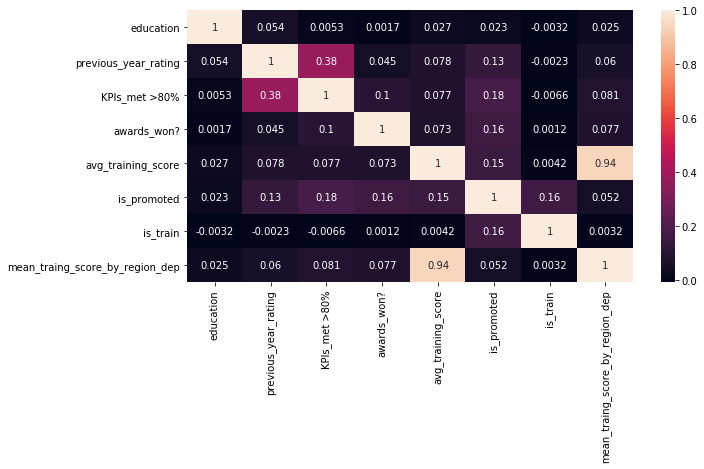

In [40]:
plt.figure(figsize=(10,5))
sns.heatmap(full.corr(), annot = True)

In [41]:
# data_viz(df=region1_operations, columns=numeric_columns,plot_type="hist")

In [42]:
# data_viz(df=region1_sales, columns=numeric_columns,plot_type="hist")

# Encoding all

In [43]:
full = pd.get_dummies(full)

# Train test split

In [44]:
drop_columns = ['is_train', 'is_promoted']
train = full[full['is_train'] ==1]
test = full[full['is_train'] == 0]
y = train['is_promoted']
train.drop(drop_columns, inplace = True, axis=1)
test.drop(drop_columns, inplace = True, axis=1)

In [45]:
y.value_counts(normalize=True)
#unbalanced target value => stratified split is required for training

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [46]:
X_train, X_val, y_train, y_val = train_test_split(train, y, stratify=y) 
# stratify attribute makes sure target value distributed evenly
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True)

(0    0.91483
 1    0.08517
 Name: is_promoted, dtype: float64,
 0    0.91483
 1    0.08517
 Name: is_promoted, dtype: float64)

# Modelling

## 1. xgboost

In [47]:
def f1_XGBoost(X_train, X_val, y_train, y_val, test_df):
    xgb_model = XGBClassifier(n_estimators=1000,
                         learning_rate=0.2,
                         colsample_bytree = 0.7,
                         colsample_bylevel = 0.7,
                         random_state=0,
                         max_depth=50,
                         verbosity=0)

    xgb_model.fit(X_train, y_train, early_stopping_rounds=24,eval_metric="logloss", eval_set=[(X_val, y_val)])
    y_predict_xgb = xgb_model.predict(X_val)
    y_test_xgb = xgb_model.predict(test_df)
    return f1_score(y_predict_xgb, y_val), y_test_xgb
    

In [48]:
f1_xgb, y_test_xgb = f1_XGBoost(X_train, X_val, y_train, y_val, test)
f1_xgb
#0.5014749262536873

[0]	validation_0-logloss:0.555743
Will train until validation_0-logloss hasn't improved in 24 rounds.
[1]	validation_0-logloss:0.460903
[2]	validation_0-logloss:0.399063
[3]	validation_0-logloss:0.346502
[4]	validation_0-logloss:0.30726
[5]	validation_0-logloss:0.2775
[6]	validation_0-logloss:0.254054
[7]	validation_0-logloss:0.23929
[8]	validation_0-logloss:0.228833
[9]	validation_0-logloss:0.220424
[10]	validation_0-logloss:0.212095
[11]	validation_0-logloss:0.204576
[12]	validation_0-logloss:0.200636
[13]	validation_0-logloss:0.195106
[14]	validation_0-logloss:0.193002
[15]	validation_0-logloss:0.189274
[16]	validation_0-logloss:0.186127
[17]	validation_0-logloss:0.184366
[18]	validation_0-logloss:0.182701
[19]	validation_0-logloss:0.181802
[20]	validation_0-logloss:0.181539
[21]	validation_0-logloss:0.18092
[22]	validation_0-logloss:0.180547
[23]	validation_0-logloss:0.181041
[24]	validation_0-logloss:0.181374
[25]	validation_0-logloss:0.18147
[26]	validation_0-logloss:0.181509
[27

0.47985347985347987

## 2. light gbm

In [49]:
def f1_LightGBM(X_train, X_val, y_train, y_val, test_df):
    lgb_model = lgb.LGBMClassifier(n_estimators=1000,
                         learning_rate=0.2,
                         random_state=0,
                         max_depth=10,
                         verbose=0)
    lgb_model.fit(X_train, y_train)
    y_predict_lgb = lgb_model.predict(X_val)
    y_test_lgb = lgb_model.predict(test_df)
    return f1_score(y_predict_lgb, y_val), y_test_lgb

In [50]:
f1_lgb, y_test_lgb = f1_LightGBM(X_train, X_val, y_train, y_val, test)
f1_lgb
#0.5043478260869565

0.4693539480949751

## 3. catboost

In [51]:
def f1_CatBoost(X_train, X_val, y_train, y_val, test_df):
    catboost_model = CatBoostClassifier(n_estimators=1000,
                         learning_rate=0.2,
                         random_state=0,
                         max_depth=10,
                         verbose=0)
    catboost_model.fit(X_train, y_train)
    y_predict_catb = catboost_model.predict(X_val)
    y_test_catb = catboost_model.predict(test_df)
    return f1_score(y_predict_catb, y_val), y_test_catb

In [52]:
f1_catb, y_test_catb = f1_CatBoost(X_train, X_val, y_train, y_val, test)
f1_catb
#0.4970286331712588

0.47334058759521214

## 4. Random forest

In [53]:
def f1_RandomForest(X_train, X_val, y_train, y_val, test_df):
    rdmf_model = RandomForestClassifier(n_estimators=1000,
                         random_state=0,
                         max_depth=50)
    rdmf_model.fit(X_train, y_train)
    y_predict_rdmf = rdmf_model.predict(X_val)
    y_test_rdmf = rdmf_model.predict(test_df)
    return f1_score(y_predict_rdmf, y_val), y_test_rdmf

In [54]:
f1_rdmf, y_test_rdmf = f1_RandomForest(X_train, X_val, y_train, y_val, test)
f1_rdmf
#0.49326805385556916

0.45439650464227194

# Output

In [55]:
output = pd.DataFrame({'employee_id': test_df.employee_id, 'is_promoted':y_test_xgb})
output.head(2)

,employee_id,is_promoted
0,8724,0
1,74430,0


In [56]:
output.to_csv("submission.csv", index=False)